In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/126 (30)_aug3.jpg_aug3.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/112 (19)_aug9.jpg_aug9.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/109 (1)_aug3.jpg_aug3.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/124 (12)_aug6.jpg_aug6.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/122 (27)_aug6.jpg_aug6.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/108 (25)_aug7.jpg_aug7.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/102 (3)_aug7.jpg_aug7.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/109 (1)_aug2.jpg_aug2.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_CT_64_augmented/99 (12) - Copy_aug5.jpg_aug5.jpg
/kaggle/input/brain-ct-sinograms-64-augmented/Datasets/brain_

In [2]:
import tensorflow as tf
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-06-30 19:03:29.131842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751310209.357296      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751310209.424385      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Paths
input_dir = '/kaggle/input/brain-ct-sinograms-64-augmented-2-0/Datasets/brain_CT_sinograms_64_augmented'
output_dir = '/kaggle/input/brain-ct-sinograms-64-augmented-2-0/Datasets/brain_CT_64_augmented'

# Get sorted file names (to ensure matching)
input_files = sorted(os.listdir(input_dir))
output_files = sorted(os.listdir(output_dir))


In [4]:
# Initialize lists
x_data = []
y_data = []

# Load images
for in_file, out_file in zip(input_files, output_files):
    # Load grayscale image and resize to (256, 256)
    input_img = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(91,64))
    output_img = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(64, 64))
    
    # Convert to array and normalize to [0, 1]
    x = img_to_array(input_img) / 255.0
    y = img_to_array(output_img) / 255.0

    x_data.append(x)
    y_data.append(y)

# Convert to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("Input shape:", x_data.shape)   # (125, 256, 256, 1)
print("Output shape:", y_data.shape)  # (125, 256, 256, 1)

Input shape: (2500, 91, 64, 1)
Output shape: (2500, 64, 64, 1)


In [5]:
x_train = x_data[:2000]
x_test = x_data[2000:]
y_train = y_data[:2000]
y_test = y_data[2000:]

In [6]:
print(x_train.shape)
print(y_train.shape)

(2000, 91, 64, 1)
(2000, 64, 64, 1)


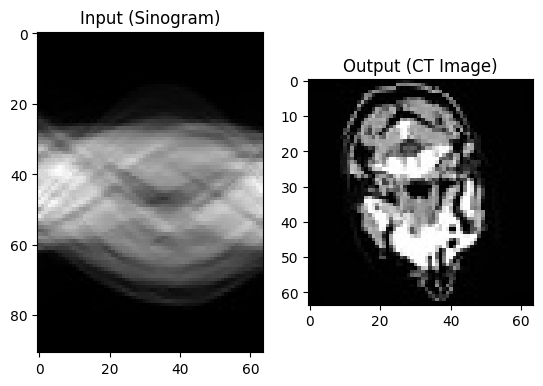

In [7]:
index = 4

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(x_data[index].squeeze(), cmap='gray')
plt.title('Input (Sinogram)')

plt.subplot(1, 2, 2)
plt.imshow(y_data[index].squeeze(), cmap='gray')
plt.title('Output (CT Image)')
plt.show()

# Model

In [8]:
from tensorflow.keras import models, layers
def build_automap(input_shape=(91, 64, 1), dropout_rate=0.3):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(64, 64),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='tanh'),
        layers.Reshape((64, 64, 1))  # 👈 This fixes the shape
    ])
    return model


In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
model = build_automap()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

I0000 00:00:1751310259.981935      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,125,248 (256.06 MB)

 Trainable params: 67,125,248 (256.06 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs= 300,
    verbose=1
)

Epoch 1/300


I0000 00:00:1751310263.447390      61 service.cc:148] XLA service 0x7e022400af70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751310263.448215      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751310263.707236      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/200 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1306 - mean_absolute_error: 0.2400

I0000 00:00:1751310264.546706      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0568 - mean_absolute_error: 0.1541 - val_loss: 0.0332 - val_mean_absolute_error: 0.1168
Epoch 2/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0333 - mean_absolute_error: 0.1164 - val_loss: 0.0300 - val_mean_absolute_error: 0.1098
Epoch 3/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0294 - mean_absolute_error: 0.1081 - val_loss: 0.0278 - val_mean_absolute_error: 0.1045
Epoch 4/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0267 - mean_absolute_error: 0.1021 - val_loss: 0.0266 - val_mean_absolute_error: 0.1019
Epoch 5/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0249 - mean_absolute_error: 0.0985 - val_loss: 0.0267 - val_mean_absolute_error: 0.1042
Epoch 6/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0235 - mean_absolute_error: 0.0956 - val_loss: 0.0256 - val_mean_absolute_error: 0.1010
Epoch 7/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0219 - mean_absolute_error: 0.0919 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


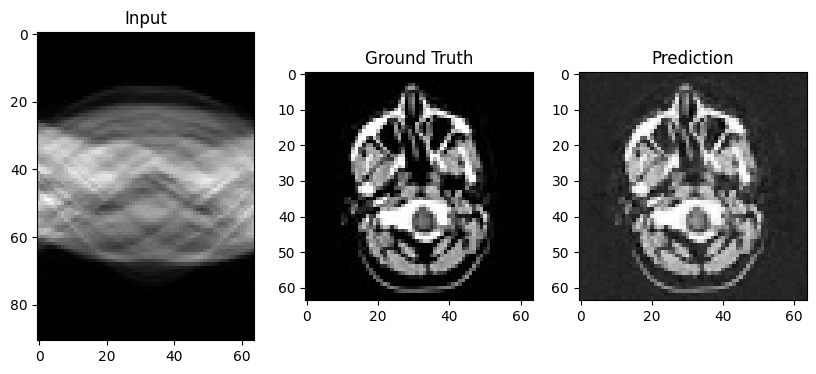

In [12]:
import matplotlib.pyplot as plt

i = 50# index of sample
pred = model.predict(x_train[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


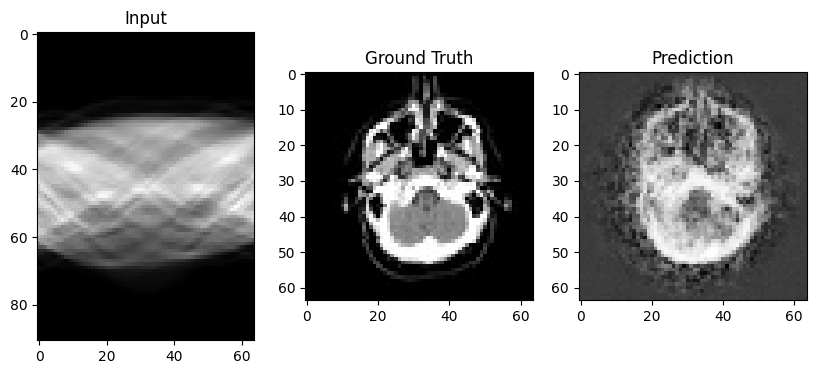

In [13]:
import matplotlib.pyplot as plt

i = 50# index of sample
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


## Evaluate

In [14]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_test[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_test[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


Average PSNR: 15.97 dB
Average SSIM: 0.3652


In [15]:
model.save('automap_model_dense_300epoch.h5')